# **Importing Dependencies**

In [1]:
# Import required libraries
import os
import kagglehub
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import multiprocessing.dummy as mp
import random
from IPython.display import Audio
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# **Downloading Dataset**

In [2]:
# Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download("sylkaladin/speech-commands-v2")
print("Path to dataset files:", dataset_path)

100%|██████████| 2.25G/2.25G [00:29<00:00, 81.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sylkaladin/speech-commands-v2/versions/1


In [3]:
# Define the target words
target_words = ['up', 'left', 'stop', 'yes', 'no']

# Collect file paths for the target words
audio_file_paths = []
audio_file_counts = {word: 0 for word in target_words}  # Initialize counts for each word

for word in target_words:
    word_folder_path = os.path.join(dataset_path, word)
    if os.path.exists(word_folder_path):
        # Get all audio files in the word folder
        audio_files = os.listdir(word_folder_path)
        for audio_file in audio_files:
            audio_file_paths.append(os.path.join(word_folder_path, audio_file))
        audio_file_counts[word] = len(audio_files)  # Update count for the current word
        print(f"Collected {len(audio_files)} files from '{word}' folder.")
    else:
        print(f"Warning: '{word}' folder not found in the dataset.")

Collected 3723 files from 'up' folder.
Collected 3801 files from 'left' folder.
Collected 3872 files from 'stop' folder.
Collected 4044 files from 'yes' folder.
Collected 3941 files from 'no' folder.


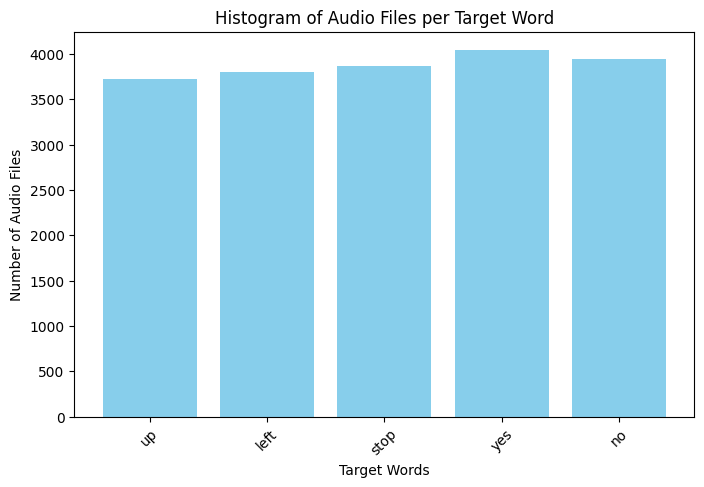

In [ ]:
# Create a histogram
plt.figure(figsize=(8, 5))
plt.bar(audio_file_counts.keys(), audio_file_counts.values(), color='skyblue')
plt.xlabel('Target Words')
plt.ylabel('Number of Audio Files')
plt.title('Histogram of Audio Files per Target Word')
plt.xticks(rotation=45)
plt.show()# Create a histogram

# **Displaying Sample Audios from Dataset**

In [ ]:
# Display 5 random audio files from the entire dataset
print("\nPlaying 5 random audio files from the dataset:")
if len(audio_file_paths) >= 5:
    random_audios = random.sample(audio_file_paths, 5)  # Pick 5 random files
    for audio_file in random_audios:
        print(f"\nPlaying random audio file: {audio_file}")
        display(Audio(filename=audio_file))  # Play the audio file
else:
    print("Not enough audio files in the dataset to play 5 random files.")


Playing 5 random audio files from the dataset:

Playing random audio file: /root/.cache/kagglehub/datasets/sylkaladin/speech-commands-v2/versions/1/up/61ab8fbc_nohash_3.wav



Playing random audio file: /root/.cache/kagglehub/datasets/sylkaladin/speech-commands-v2/versions/1/yes/189cbabe_nohash_0.wav



Playing random audio file: /root/.cache/kagglehub/datasets/sylkaladin/speech-commands-v2/versions/1/stop/019fa366_nohash_1.wav



Playing random audio file: /root/.cache/kagglehub/datasets/sylkaladin/speech-commands-v2/versions/1/stop/964e8cfd_nohash_1.wav



Playing random audio file: /root/.cache/kagglehub/datasets/sylkaladin/speech-commands-v2/versions/1/up/cab100c9_nohash_0.wav


# **Data Preprocessing**

In [4]:
# Sampling rate
sampling_rate = 16000
# Function to load a single file and extract filename, label, and audio data
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=sampling_rate)
    label = os.path.basename(os.path.dirname(file_path))  # Folder name as the label
    filename = os.path.basename(file_path)  # File name without path
    return filename, label, y

In [5]:
# Use thread-based multiprocessing to load files in parallel
with mp.Pool(os.cpu_count()) as pool:  # Using os.cpu_count() for the number of threads
    audio_data = pool.map(load_audio, audio_file_paths)

In [13]:
# Organize results into a DataFrame with filename, label, and audio data
audio_df = pd.DataFrame(audio_data, columns=['filename', 'label', 'audio_data'])

In [14]:
audio_df.head()

,filename,label,audio_data
0,22296dbe_nohash_1.wav,up,"[-6.1035156e-05, -0.00045776367, -0.0008544922..."
1,7d4beb11_nohash_1.wav,up,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,08ab231c_nohash_2.wav,up,"[-0.00021362305, -0.00024414062, 0.00039672852..."
3,5f9cd2eb_nohash_6.wav,up,"[0.0, 6.1035156e-05, 3.0517578e-05, 3.0517578e..."
4,004ae714_nohash_0.wav,up,"[-0.001953125, -0.0007019043, -0.0019226074, -..."


In [15]:
# Function to extract MFCCs for a single audio sample
def extract_mfcc_parallel(audio_data, sr, n_mfcc=13):
    return librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=n_mfcc).T

In [16]:
# Prepare data for parallel processing
audio_data_list = audio_df['audio_data'].tolist()

# Use thread-based multiprocessing to extract MFCCs in parallel
with mp.Pool(os.cpu_count()) as pool:
    mfcc_features = pool.starmap(extract_mfcc_parallel, [(audio, sampling_rate) for audio in audio_data_list])

# Add the extracted MFCC features to the DataFrame
audio_df['mfcc'] = mfcc_features

# Convert list of arrays (MFCCs) into a 2D array for standardization
mfcc_flattened = np.concatenate(audio_df['mfcc'].values, axis=0)

# Initialize the scaler and fit only on the flattened MFCCs (training data only)
scaler = StandardScaler().fit(mfcc_flattened)

In [17]:
audio_df.head()

,filename,label,audio_data,mfcc
0,22296dbe_nohash_1.wav,up,"[-6.1035156e-05, -0.00045776367, -0.0008544922...","[[-514.84906, 58.258026, 5.8946285, 15.326365,..."
1,7d4beb11_nohash_1.wav,up,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-741.05206, 5.063404, 4.777813, 4.3203506, 3..."
2,08ab231c_nohash_2.wav,up,"[-0.00021362305, -0.00024414062, 0.00039672852...","[[-502.97552, 39.832977, 17.721191, 4.693671, ..."
3,5f9cd2eb_nohash_6.wav,up,"[0.0, 6.1035156e-05, 3.0517578e-05, 3.0517578e...","[[-626.59674, 3.8140612, -20.736008, -12.41194..."
4,004ae714_nohash_0.wav,up,"[-0.001953125, -0.0007019043, -0.0019226074, -...","[[-452.54422, 18.316645, -28.898758, 56.171333..."


In [18]:
# Function to apply scaler to each sample
def scale_features(features, scaler):
    scaled_features = []
    for feature in features:
        scaled = scaler.transform(feature)  # Standardize each sample
        scaled_features.append(scaled)
    return np.array(scaled_features, dtype=object)

In [19]:
# Apply scaling to MFCC features
audio_df['scaled_mfcc'] = scale_features(audio_df['mfcc'].values, scaler)
audio_df.head()

,filename,label,audio_data,mfcc,scaled_mfcc
0,22296dbe_nohash_1.wav,up,"[-6.1035156e-05, -0.00045776367, -0.0008544922...","[[-514.84906, 58.258026, 5.8946285, 15.326365,...","[[-0.6667153, -0.22409093, 0.13821156, 0.14018..."
1,7d4beb11_nohash_1.wav,up,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-741.05206, 5.063404, 4.777813, 4.3203506, 3...","[[-1.9832718, -1.0134819, 0.10943102, -0.24666..."
2,08ab231c_nohash_2.wav,up,"[-0.00021362305, -0.00024414062, 0.00039672852...","[[-502.97552, 39.832977, 17.721191, 4.693671, ...","[[-0.59760845, -0.49751264, 0.4429843, -0.2335..."
3,5f9cd2eb_nohash_6.wav,up,"[0.0, 6.1035156e-05, 3.0517578e-05, 3.0517578e...","[[-626.59674, 3.8140612, -20.736008, -12.41194...","[[-1.3171141, -1.0320215, -0.548065, -0.834785..."
4,004ae714_nohash_0.wav,up,"[-0.001953125, -0.0007019043, -0.0019226074, -...","[[-452.54422, 18.316645, -28.898758, 56.171333...","[[-0.30408597, -0.81680804, -0.75842065, 1.575..."


In [22]:
# Plot audio data for visualization
def plot_audio_sample(audio_sample):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(13, 7))

    # 1. Waveform
    librosa.display.waveshow(audio_sample, sr=sampling_rate, ax=axes[0, 0])
    axes[0, 0].set_title("Waveform")
    axes[0, 0].set_xlabel("Time (s)")
    axes[0, 0].set_ylabel("Amplitude")

    # 2. Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_sample)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log', ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title("Spectrogram")
    axes[0, 1].set_xlabel("Time (s)")
    axes[0, 1].set_ylabel("Frequency (Hz)")

    # 3. MFCC
    mfccs = librosa.feature.mfcc(y=audio_sample, sr=sampling_rate, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time', sr=sampling_rate, ax=axes[1, 0])
    axes[1, 0].set_title("MFCC")
    axes[1, 0].set_xlabel("Time (s)")
    axes[1, 0].set_ylabel("MFCC Coefficients")
    fig.colorbar(librosa.display.specshow(mfccs, x_axis='time', sr=sampling_rate, ax=axes[1, 0]), ax=axes[1, 0])

    # 4. Chromagram
    chroma = librosa.feature.chroma_stft(y=audio_sample, sr=sampling_rate)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sampling_rate, ax=axes[1, 1])
    axes[1, 1].set_title("Chromagram")
    axes[1, 1].set_xlabel("Time (s)")
    axes[1, 1].set_ylabel("Pitch Class")
    fig.colorbar(librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sampling_rate, ax=axes[1, 1]), ax=axes[1, 1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

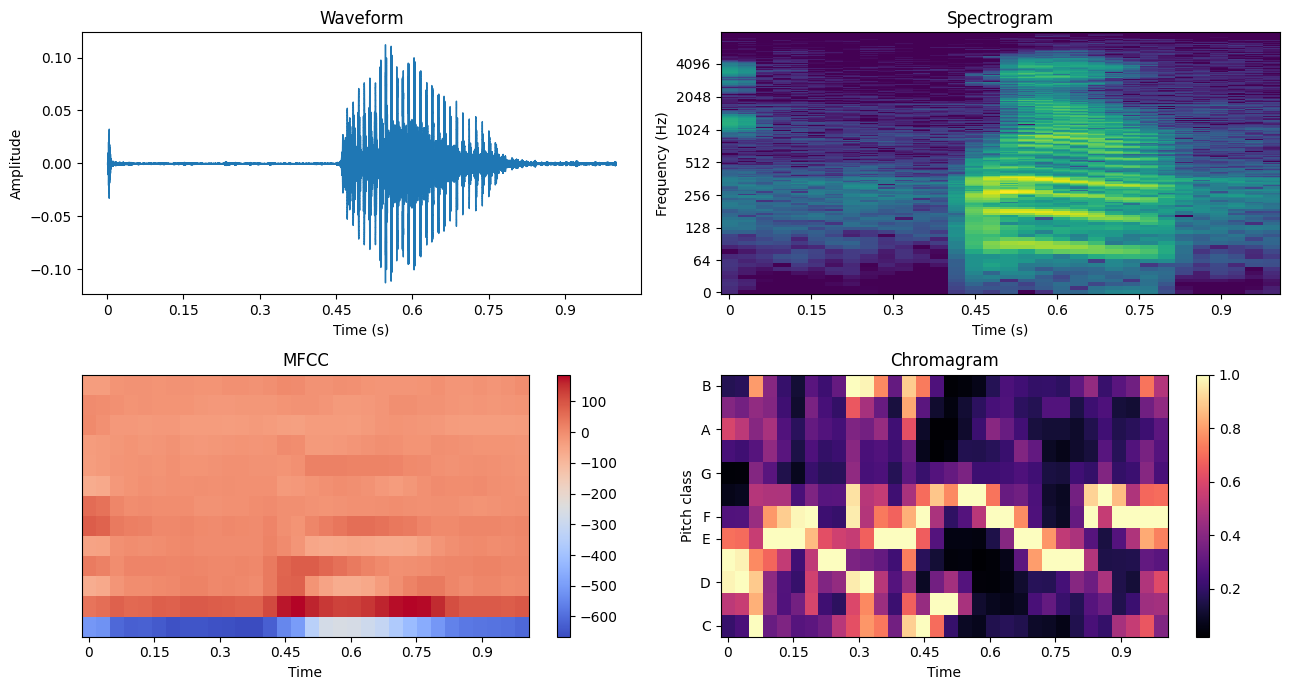

In [23]:
# Plot an example audio sample
audio_sample = audio_df[audio_df['label'] == 'no']['audio_data'].iloc[0]
plot_audio_sample(audio_sample)

In [24]:
# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(audio_df['scaled_mfcc'], audio_df['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train, padding='post')
X_test_padded = pad_sequences(X_test, padding='post')
X_val_padded = pad_sequences(X_val, padding='post')

In [25]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

# **Modelling**

In [ ]:
# Define and train the model (same as in the original notebook)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(target_words), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# **Model Training**

In [ ]:
# Train the model
history = model.fit(
    X_train_padded,
    y_train,
    epochs=20,
    validation_data=(X_val_padded, y_val),
    callbacks=[ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)]
)

Epoch 1/20
483/485 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9719 - loss: 0.0788
Epoch 1: val_accuracy improved from -inf to 0.94324, saving model to best_model.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9719 - loss: 0.0788 - val_accuracy: 0.9432 - val_loss: 0.1973
Epoch 2/20
484/485 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9771 - loss: 0.0690
Epoch 2: val_accuracy improved from 0.94324 to 0.94427, saving model to best_model.keras
485/485 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9771 - loss: 0.0690 - val_accuracy: 0.9443 - val_loss: 0.2048
Epoch 3/20
479/485 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9742 - loss: 0.0731
Epoch 3: val_accuracy did not improve from 0.94427
485/485 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9742 - loss: 0.0730 - val_accuracy: 0.9422 - val_loss: 0.2078
Epoch 4/20
481/485 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9772 - loss: 0.0615
Epoch 4: val_accuracy did not improve from 0.94427
485/485 ━━━━━━━━━━━━━━━━━━

# **Model Evaluation**

In [ ]:
# Evaluate the model
best_model = tf.keras.models.load_model('best_model.keras')
train_loss, train_accuracy = best_model.evaluate(X_train_padded, y_train)
val_loss, val_accuracy = best_model.evaluate(X_val_padded, y_val)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9965 - loss: 0.0145
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9445 - loss: 0.2262
Training Accuracy: 0.9962
Validation Accuracy: 0.9494


In [6]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = '/content/drive/My Drive/my_model.h5'

In [ ]:
# Saving the model
model.save(save_path)

# **Model Loading & Evaluation using Confusion Matrix and Classification Report**

In [7]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Sign Language AI/Saved Model/my_model.h5')

In [ ]:
# Assuming you have X_test_padded and y_test from your previous code
y_pred_probs = model.predict(X_test_padded)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


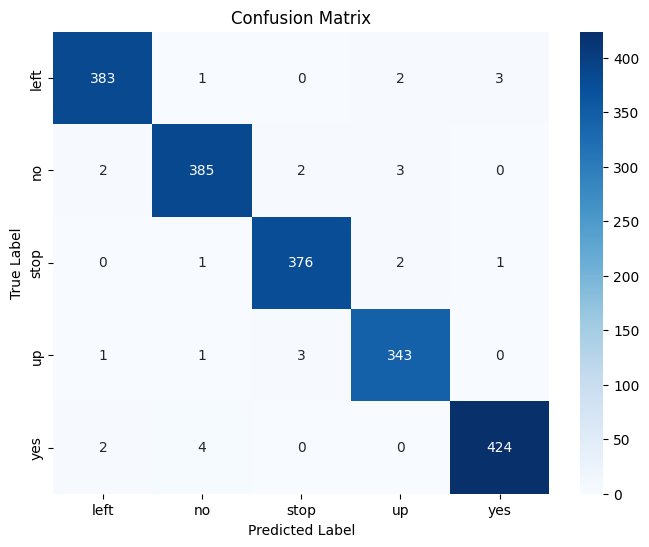

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print classification report for precision, recall, F1-score
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
# Calculate overall accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Overall Accuracy: {accuracy:.4f}")

              precision    recall  f1-score   support

        left       0.99      0.98      0.99       389
          no       0.98      0.98      0.98       392
        stop       0.99      0.99      0.99       380
          up       0.98      0.99      0.98       348
         yes       0.99      0.99      0.99       430

    accuracy                           0.99      1939
   macro avg       0.99      0.99      0.99      1939
weighted avg       0.99      0.99      0.99      1939

Overall Accuracy: 0.9856


# **Testing**

In [28]:
# 1. Load the saved model and label encoder
model = tf.keras.models.load_model('/content/drive/MyDrive/Sign Language AI/Saved Model/my_model.h5')  # Replace with your model path

In [29]:
# 2. Define a function to preprocess audio (same as before)
def preprocess_audio(audio_path):
  audio, sr = librosa.load(audio_path, sr=16000)  # Use the sampling rate used during training
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T
  scaled_mfccs = scaler.transform(mfccs)  # Assuming 'scaler' is the StandardScaler object used during training
  padded_mfccs = pad_sequences([scaled_mfccs], padding='post', maxlen=X_train_padded.shape[1])  # Use the same maxlen as during training
  return padded_mfccs

In [30]:
# 3. Function to predict and display audio + prediction
def predict_and_display(audio_path):
    # Load the audio data using librosa to get the sample rate
    audio_data, sample_rate = librosa.load(audio_path, sr=None)  # sr=None to use the native sample rate

    # Display audio with the sample rate
    display(Audio(data=audio_data, rate=sample_rate))

    # Get prediction (rest of the function remains the same)
    audio_features = preprocess_audio(audio_path)
    prediction = model.predict(audio_features)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]

    print(f"Audio file: {audio_path}")
    print(f"Predicted label: {predicted_label}")
    print("-" * 20)  # Separator

In [33]:
# 4. Define paths to your 5 audio files
audio_files = [
    '/content/drive/MyDrive/Sign Language AI/Test Audio/audio1.waptt.wav',
    '/content/drive/MyDrive/Sign Language AI/Test Audio/audio2.waptt.wav',
    '/content/drive/MyDrive/Sign Language AI/Test Audio/audio3.waptt.wav',
    '/content/drive/MyDrive/Sign Language AI/Test Audio/audio4.waptt.wav',
    '/content/drive/MyDrive/Sign Language AI/Test Audio/audio5.waptt.wav',
]

# 5. Loop through files and predict
for audio_file in audio_files:
    predict_and_display(audio_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Audio file: /content/drive/MyDrive/Sign Language AI/Test Audio/audio1.waptt.wav
Predicted label: no
--------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Audio file: /content/drive/MyDrive/Sign Language AI/Test Audio/audio2.waptt.wav
Predicted label: yes
--------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Audio file: /content/drive/MyDrive/Sign Language AI/Test Audio/audio3.waptt.wav
Predicted label: stop
--------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Audio file: /content/drive/MyDrive/Sign Language AI/Test Audio/audio4.waptt.wav
Predicted label: left
--------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Audio file: /content/drive/MyDrive/Sign Language AI/Test Audio/audio5.waptt.wav
Predicted label: up
--------------------
